test multi-task optimisation in 2D

use branch `multi-task` to run this notebook!

In [1]:
import numpy as np
from boss.bo.bo_main import BOMain

In [2]:
import matplotlib.pyplot as plt

In [3]:
seed=221017

utilities:

In [4]:
import GPy

In [5]:
def load_model(filename):

    # load saved data
    saved=np.load(filename)
    dim=saved['X'].shape[1]

    # create kernel
    k=GPy.kern.StdPeriodic(input_dim=dim,ARD1=True,ARD2=True)

    # create mean function
    mf=GPy.mappings.Constant(dim,1)

    # create model
    m=GPy.models.GPRegression(saved['X'],saved['Y'],kernel=k,mean_function=mf)

    # set model params
    m[:]=saved['params']
    m.fix()
    m.parameters_changed()

    return m

optimisation task:

In [6]:
def f_0(x):
    return unknown_model_0.predict(np.atleast_2d(x))[0]

def f_1(x):
    return unknown_model_1.predict(np.atleast_2d(x))[0]

def f_2(x):
    return unknown_model_2.predict(np.atleast_2d(x))[0]

In [7]:
unknown_model_0=load_model('../models/model_2D_E0.npz')
unknown_model_1=load_model('../models/model_2D_E1.npz')
unknown_model_2=load_model('../models/model_2D_E2.npz')
bounds=[[-50.0, 310.0]]*2

plot:

In [8]:
xp = np.linspace(-50, 310, 361)
levels = 25

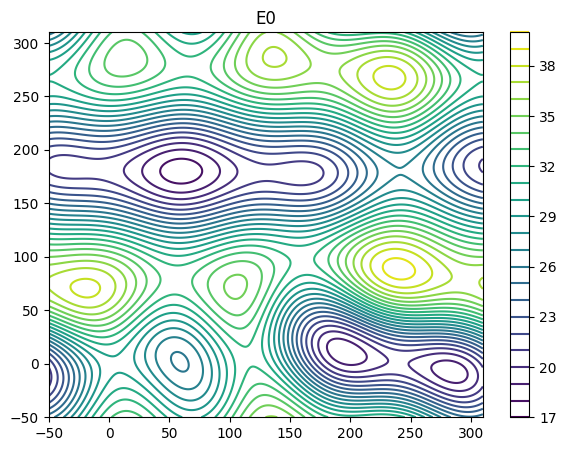

In [9]:
x1, x2 = np.meshgrid(xp,xp) 
yp = f_0(np.column_stack((x1.ravel(),x2.ravel())))
plt.figure(figsize=(7,5))
cset = plt.contour(xp, xp, yp.reshape(len(xp),len(xp)), levels=levels)
plt.colorbar(cset)
plt.title('E0');

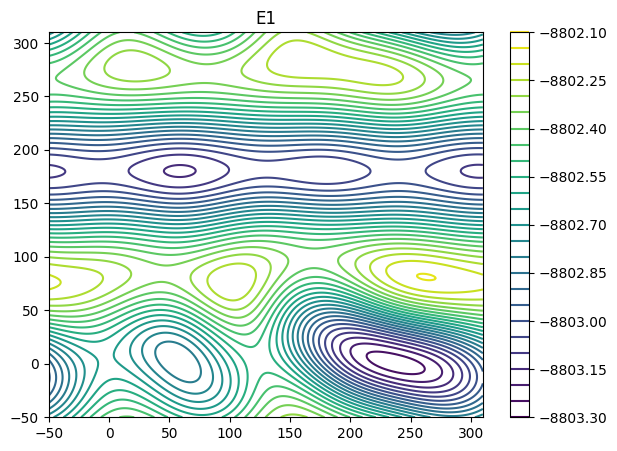

In [10]:
yp = f_1(np.column_stack((x1.ravel(),x2.ravel())))
plt.figure(figsize=(7,5))
cset = plt.contour(xp, xp, yp.reshape(len(xp),len(xp)), levels=levels)
plt.colorbar(cset)
plt.title('E1');

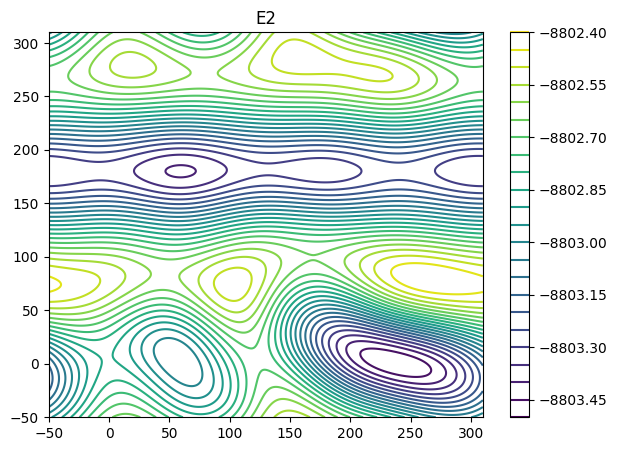

In [11]:
yp = f_2(np.column_stack((x1.ravel(),x2.ravel())))
plt.figure(figsize=(7,5))
cset = plt.contour(xp, xp, yp.reshape(len(xp),len(xp)), levels=levels)
plt.colorbar(cset)
plt.title('E2');

## baseline optimisation

use E2 acquisitions to find the coordinates that minimise E2

In [12]:
bo_1 = BOMain(
    f_2, 
    bounds,
    yrange=[0, 1],
    kernel='stdp',
    initpts=5,
    iterpts=20,
    seed=seed
)

In [13]:
%time res_1 = bo_1.run()

CPU times: user 11.9 s, sys: 594 ms, total: 12.5 s
Wall time: 11.2 s


In [14]:
[res_1.xbest, res_1.ybest]

[array([246.9218001 , -10.74647173]), -8803.456642189456]

In [15]:
[res_1.xmin, res_1.fmin]

[array([246.92276148, -10.74149298]), -8803.456667435408]

evaluate estimated minimum:

In [16]:
f_2(res_1.xmin)

array([[-8803.45667586]])

plot:

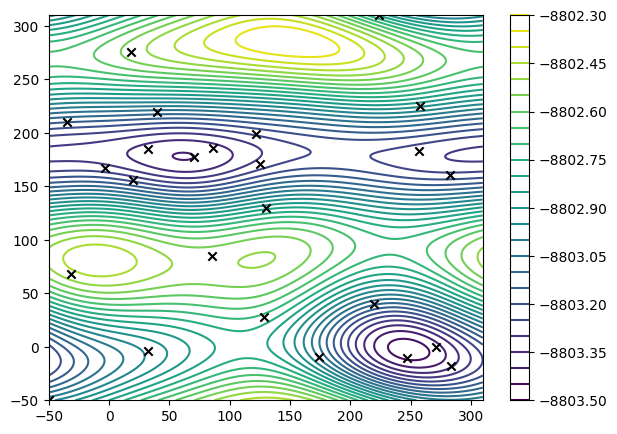

In [17]:
yp = bo_1.model.predict(np.column_stack((x1.ravel(),x2.ravel())))[0]
plt.figure(figsize=(7,5))
cset = plt.contour(xp, xp, yp.reshape(len(xp),len(xp)), levels=levels)
plt.colorbar(cset)
plt.scatter(bo_1.model.X[:,0],bo_1.model.X[:,1], marker='x', color='k', zorder=10);

## multi-task optimisation

associate acquisitions with a cost:

In [18]:
cost_0 = 0.1
cost_1 = 1
cost_2 = 2

add maximum cost limit to optimisation:

In [19]:
maxcost = 25 * cost_2

example 1: use E2 and E0 acquisitions to find the coordinates that minimise E2

In [20]:
bo_2 = BOMain(
    [f_2, f_0],
    bounds,
    num_tasks=2,
    kernel='stdp',
    initpts=5,
    iterpts=500,
    seed=seed,
    maxcost=maxcost,
    acqcost=[cost_2, cost_0]
)

In [21]:
%time res_2 = bo_2.run()

CPU times: user 1min 50s, sys: 10.2 s, total: 2min
Wall time: 1min 31s


In [22]:
[res_2.xbest, res_2.ybest]

[array([234.90671625,   3.02853107]), -8803.49034608283]

In [23]:
[res_2.xmin, res_2.fmin]

[array([238.09287559,   1.0162477 ]), -8803.491268248317]

evaluate estimated minimum:

In [24]:
f_2(res_2.xmin)

array([[-8803.49153557]])

plot:

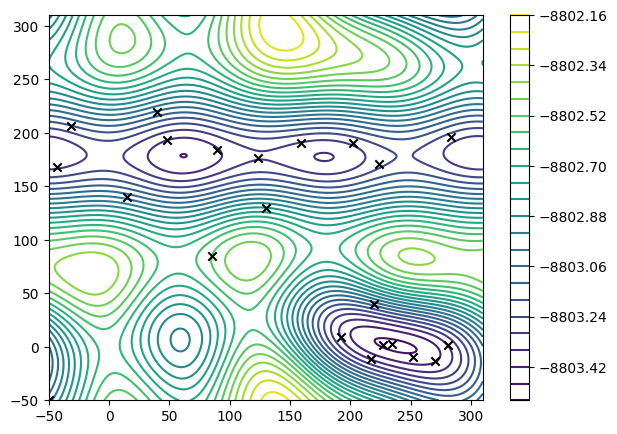

In [25]:
yp = bo_2.model.predict(np.column_stack((x1.ravel(),x2.ravel())))[0]
plt.figure(figsize=(7,5))
cset = plt.contour(xp, xp, yp.reshape(len(xp),len(xp)), levels=levels)
plt.colorbar(cset)
plt.scatter(bo_2.model.X[:,0], bo_2.model.X[:,1], marker='x', color='k', zorder=10);

support task:

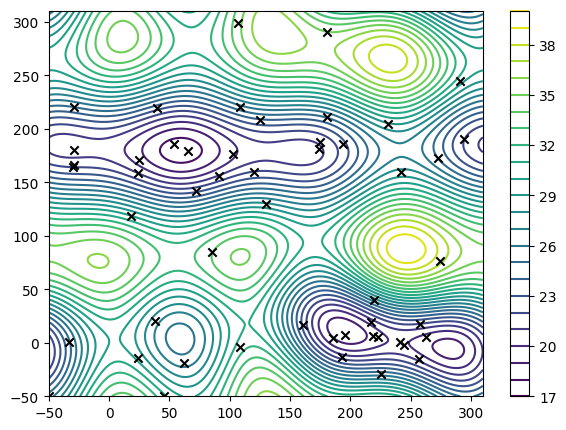

In [26]:
yp = bo_2.model.predict(np.column_stack((x1.ravel(),x2.ravel())), index=1)[0]
plt.figure(figsize=(7,5))
cset = plt.contour(xp, xp, yp.reshape(len(xp),len(xp)), levels=levels)
plt.colorbar(cset)
plt.scatter(bo_2.model.get_X(index=1)[:,0],bo_2.model.get_X(index=1)[:,1], marker='x', color='k', zorder=10);

num evaluations:

In [27]:
dict(zip(['E2', 'E0'], np.bincount(bo_2.model.inds)))

{'E2': 22, 'E0': 51}

compare acquisitions locations:

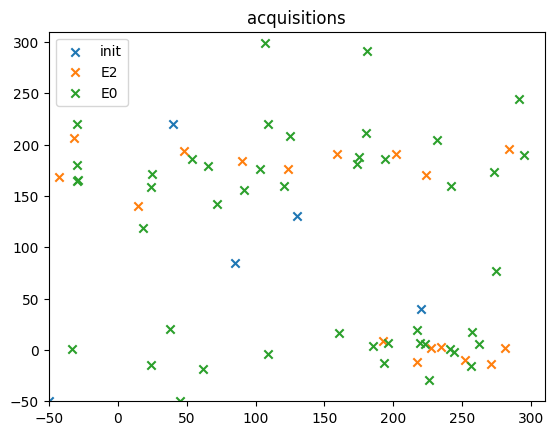

In [28]:
plt.scatter(bo_2.model.get_X(index=0)[:bo_2.initpts[0],0],bo_2.model.get_X(index=0)[:bo_2.initpts[0],1],marker='x',label='init')
plt.scatter(bo_2.model.get_X(index=0)[bo_2.initpts[0]:,0],bo_2.model.get_X(index=0)[bo_2.initpts[0]:,1],marker='x',label='E2')
plt.scatter(bo_2.model.get_X(index=1)[bo_2.initpts[1]:,0],bo_2.model.get_X(index=1)[bo_2.initpts[1]:,1],marker='x',label='E0')
plt.xlim(bounds[0])
plt.ylim(bounds[1])
plt.legend()
plt.title('acquisitions');

example 2: use E2-E0 acquisitions to find the coordinates that minimise E2

In [29]:
bo_3 = BOMain(
    [f_2, f_1, f_0],
    bounds,
    num_tasks=3,
    kernel='stdp',
    initpts=5,
    iterpts=500,
    seed=seed,
    maxcost=maxcost,
    acqcost=[cost_2, cost_1, cost_0]
)

In [30]:
%time res_3 = bo_3.run()

CPU times: user 3min 32s, sys: 24.3 s, total: 3min 57s
Wall time: 2min 37s


In [31]:
[res_3.xbest, res_3.ybest]

[array([227.20301389,   1.57528557]), -8803.485701901402]

In [32]:
[res_3.xmin, res_3.fmin]

[array([236.70371349,   0.83366674]), -8803.49074736912]

evaluate estimated minimum:

In [33]:
f_2(res_3.xmin)

array([[-8803.49155776]])

plot:

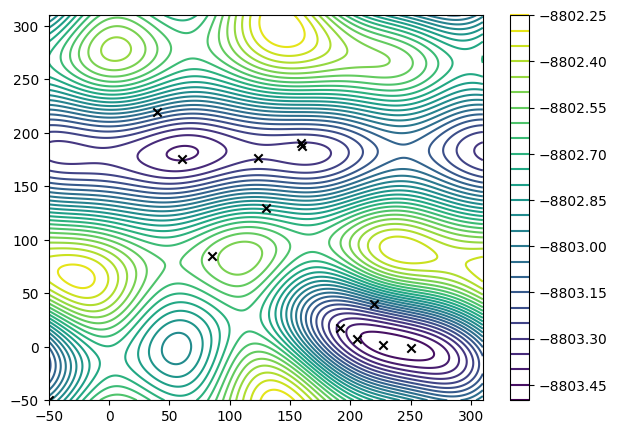

In [34]:
yp = bo_3.model.predict(np.column_stack((x1.ravel(),x2.ravel())))[0]
plt.figure(figsize=(7,5))
cset = plt.contour(xp, xp, yp.reshape(len(xp),len(xp)), levels=levels)
plt.colorbar(cset)
plt.scatter(bo_3.model.X[:,0], bo_3.model.X[:,1], marker='x', color='k', zorder=10);

support task:

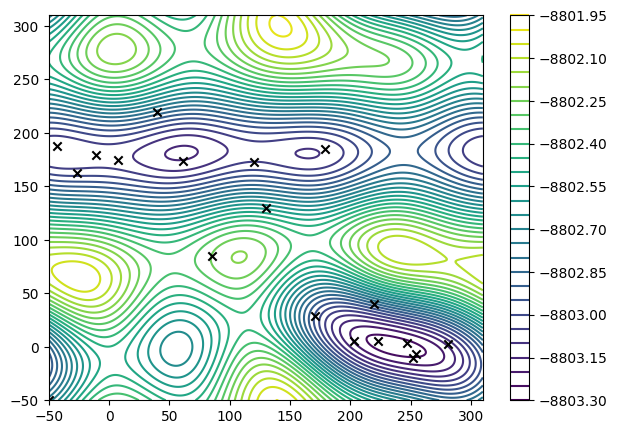

In [35]:
yp = bo_3.model.predict(np.column_stack((x1.ravel(),x2.ravel())), index=1)[0]
plt.figure(figsize=(7,5))
cset = plt.contour(xp, xp, yp.reshape(len(xp),len(xp)), levels=levels)
plt.colorbar(cset)
plt.scatter(bo_3.model.get_X(index=1)[:,0],bo_3.model.get_X(index=1)[:,1], marker='x', color='k', zorder=10);

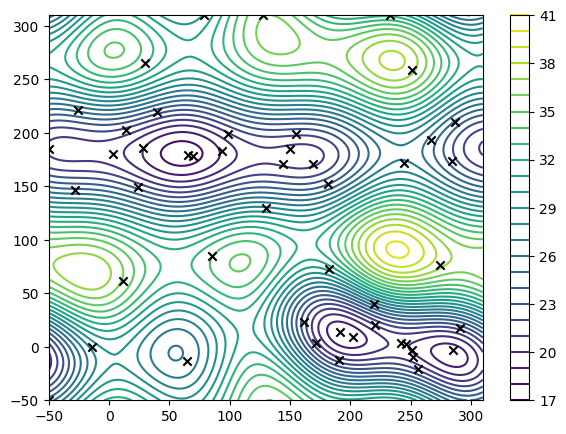

In [36]:
yp = bo_3.model.predict(np.column_stack((x1.ravel(),x2.ravel())), index=2)[0]
plt.figure(figsize=(7,5))
cset = plt.contour(xp, xp, yp.reshape(len(xp),len(xp)), levels=levels)
plt.colorbar(cset)
plt.scatter(bo_3.model.get_X(index=2)[:,0],bo_3.model.get_X(index=2)[:,1], marker='x', color='k', zorder=10);

num evaluations:

In [37]:
dict(zip(['E2', 'E1', 'E0'], np.bincount(bo_3.model.inds)))

{'E2': 13, 'E1': 19, 'E0': 48}

compare acquisition locations:

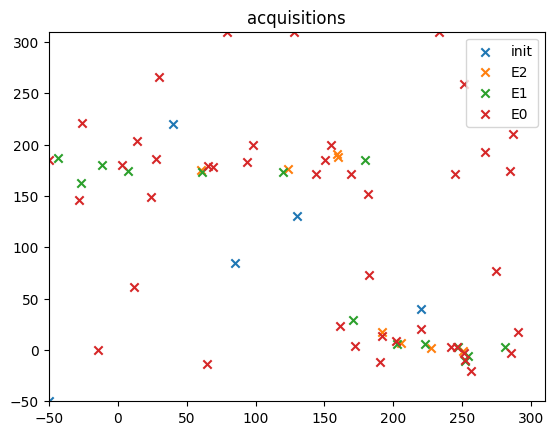

In [38]:
plt.scatter(bo_3.model.get_X(index=0)[:bo_3.initpts[0],0],bo_3.model.get_X(index=0)[:bo_3.initpts[0],1],marker='x',label='init')
plt.scatter(bo_3.model.get_X(index=0)[bo_3.initpts[0]:,0],bo_3.model.get_X(index=0)[bo_3.initpts[0]:,1],marker='x',label='E2')
plt.scatter(bo_3.model.get_X(index=1)[bo_3.initpts[1]:,0],bo_3.model.get_X(index=1)[bo_3.initpts[1]:,1],marker='x',label='E1')
plt.scatter(bo_3.model.get_X(index=2)[bo_3.initpts[2]:,0],bo_3.model.get_X(index=2)[bo_3.initpts[2]:,1],marker='x',label='E0')
plt.xlim(bounds[0])
plt.ylim(bounds[1])
plt.legend()
plt.title('acquisitions');

compare optimisation outcomes:

In [39]:
f_2(res_1.xmin)

array([[-8803.45667586]])

In [40]:
f_2(res_2.xmin)

array([[-8803.49153557]])

In [41]:
f_2(res_3.xmin)

array([[-8803.49155776]])